# Analysis of the Metro Simulation with PSO

In this notebook we present a detailed analysis of a metro system simulation in which we have incorporated a **Particle Swarm Optimization (PSO)** algorithm to determine:

1. **How often** trains should run (optimal frequency).  
2. **How many trains** should operate throughout the day to minimize passenger waiting time.

Using the `event_log.csv` generated by the simulation, we explore:

- **Distribution of passenger waiting times** and average wait per station.  
- **Actual headways** (intervals) between trains, both globally and by station.  
- **Temporal demand patterns**, including a circular histogram of events by hour.

This analysis allows us to verify how PSO tunes train frequency and fleet size to improve system efficiency and reduce passenger waiting times.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV (adjust path if needed)
df = pd.read_csv('event_log.csv')
df.head()


,Time,Event,Entity,Station,Train,Direction,Destination
0,06:00,Arrives,P824672,Tres Olivos,NaN,NaN,Paco de Lucia
1,06:00,Arrives,P824673,Sanchinarro,NaN,NaN,Mirasierra
2,06:01,Arrives,Train_5,Castellana,Train_5,counterclockwise,NaN
3,06:01,Arrives,Train_7,Castellana,Train_7,counterclockwise,NaN
4,06:01,Arrives,P824674,Las Tablas,NaN,NaN,Montecarmelo


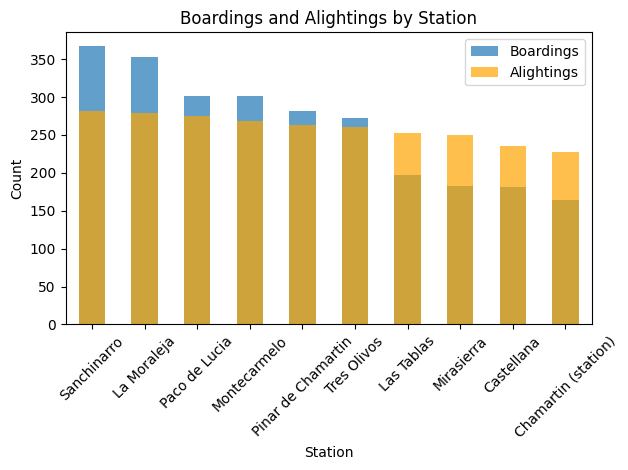

In [5]:
boardings = df[df['Event'] == 'Boards']['Station'].value_counts()
alightings = df[df['Event'] == 'Alights']['Station'].value_counts()

boardings.plot(kind='bar', alpha=0.7, label='Boardings')
alightings.plot(kind='bar', alpha=0.7, label='Alightings', color='orange')
plt.title('Boardings and Alightings by Station')
plt.xlabel('Station')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

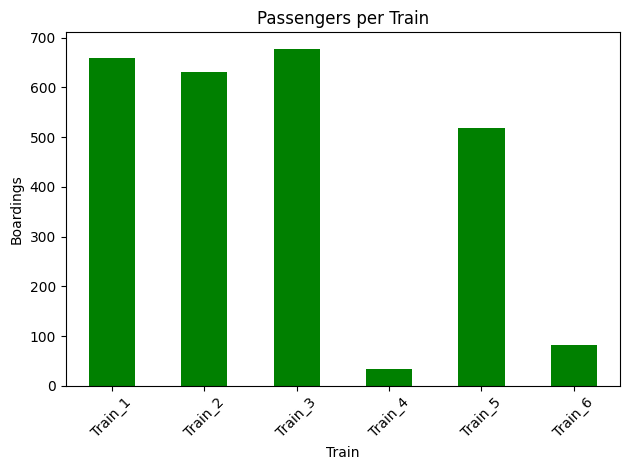

In [3]:
train_passengers = df[df['Event'] == 'Boards']['Train'].value_counts().sort_index()
train_passengers.plot(kind='bar', color='green')
plt.title('Passengers per Train')
plt.xlabel('Train')
plt.ylabel('Boardings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

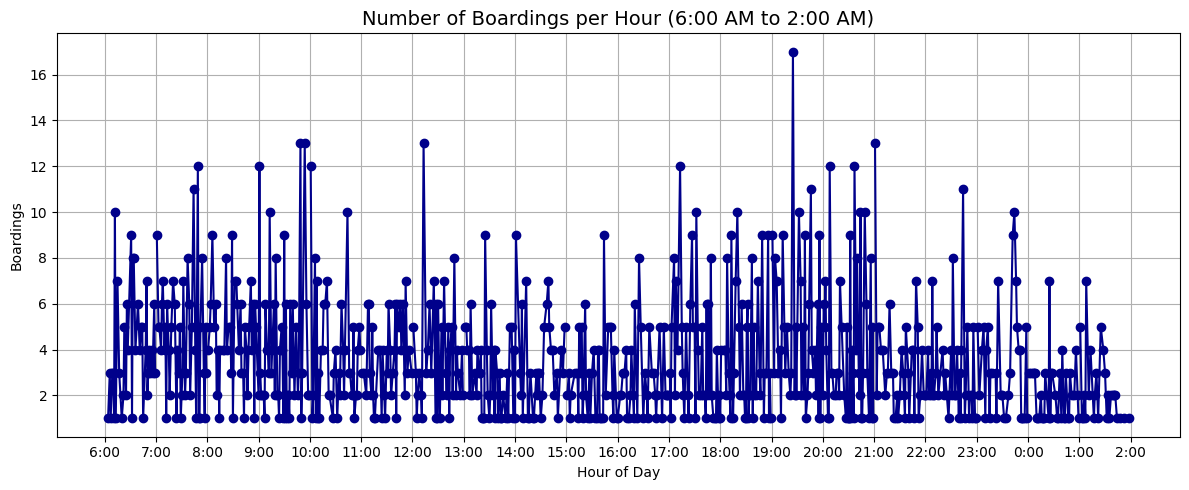

In [6]:
# We filter only boarding events
boardings = df[df['Event'] == 'Boards'].copy()

# We convert Time to datetime and we extract the hour and minutes
boardings['Time'] = pd.to_datetime(boardings['Time'], format='%H:%M')
boardings['Hour'] = boardings['Time'].dt.hour + boardings['Time'].dt.minute / 60

# We change the AM hours (0 – 2 AM) to 24 – 26
boardings['AdjustedHour'] = boardings['Hour'].apply(lambda h: h + 24 if h < 6 else h)

# We group by hour and count boardings
hourly_boardings = boardings.groupby('AdjustedHour').size()

full_range = pd.Series(index=range(6, 27), dtype='float64')
hourly_boardings = full_range.add(hourly_boardings, fill_value=0)

plt.figure(figsize=(12, 5))
plt.plot(hourly_boardings.index, hourly_boardings.values, marker='o', linestyle='-', color='darkblue')

plt.title('Number of Boardings per Hour (6:00 AM to 2:00 AM)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Boardings')
plt.xticks(ticks=range(6, 27), labels=[f"{h%24}:00" for h in range(6, 27)])
plt.grid(True)
plt.tight_layout()
plt.show()

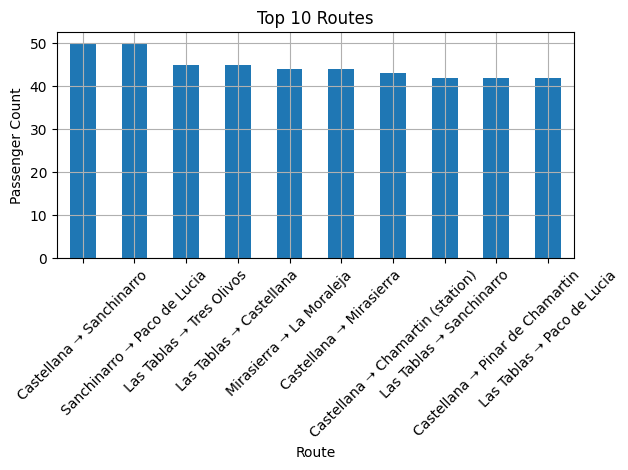

In [7]:
df_trips = df[df['Event'] == 'Boards'][['Entity', 'Station']]
destinations = df[df['Event'] == 'Alights'][['Entity', 'Station']].rename(columns={'Station': 'Destination'})
routes = pd.merge(df_trips, destinations, on='Entity')
routes['Route'] = routes['Station'] + " ➝ " + routes['Destination']

routes['Route'].value_counts().head(10).plot(kind='bar', title='Top 10 Routes')
plt.xlabel('Route')
plt.ylabel('Passenger Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

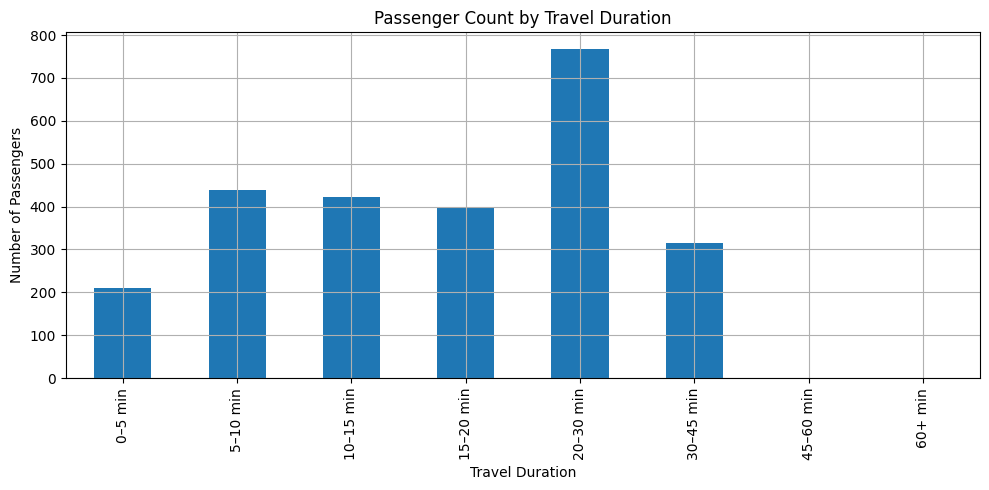

In [9]:
# We filter and merge boarding and alighting events
boards = df[df['Event'] == 'Boards'][['Entity', 'Time']].rename(columns={'Time': 'BoardingTime'})
alights = df[df['Event'] == 'Alights'][['Entity', 'Time']].rename(columns={'Time': 'AlightingTime'})
merged = pd.merge(boards, alights, on='Entity')

# Time columns to datetime objects
merged['BoardingTime'] = pd.to_datetime(merged['BoardingTime'], format='%H:%M')
merged['AlightingTime'] = pd.to_datetime(merged['AlightingTime'], format='%H:%M')

# Calculation of the travel duration
merged['TravelTime_minutes'] = (merged['AlightingTime'] - merged['BoardingTime']).dt.total_seconds() / 60

bins = [0, 5, 10, 15, 20, 30, 45, 60, float('inf')]
labels = ['0–5 min', '5–10 min', '10–15 min', '15–20 min', '20–30 min', '30–45 min', '45–60 min', '60+ min']
merged['DurationRange'] = pd.cut(merged['TravelTime_minutes'], bins=bins, labels=labels, right=False)

duration_counts = merged['DurationRange'].value_counts().sort_index()

duration_counts.plot(kind='bar', figsize=(10, 5), title='Passenger Count by Travel Duration')
plt.xlabel('Travel Duration')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

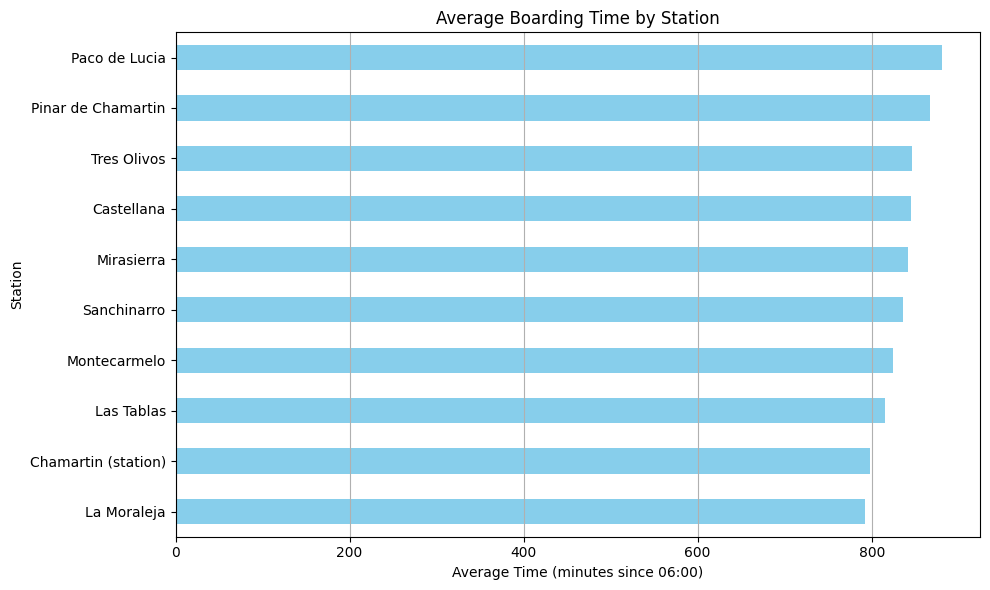

In [10]:
# We filter the boardings
df_board = df[df['Event'] == 'Boards'].copy()
df_board['Minute'] = df_board['Time'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))

# We calculte the the average time of boarding pero station
avg_boarding_time = df_board.groupby('Station')['Minute'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_boarding_time.plot(kind='barh', color='skyblue')
plt.title('Average Boarding Time by Station')
plt.xlabel('Average Time (minutes since 06:00)')
plt.ylabel('Station')
plt.grid(axis='x')
plt.tight_layout()
plt.show()



,Boards,Alights
Station,,
Castellana,367,236
Chamartin (station),282,228
La Moraleja,197,279
Las Tablas,353,253
Mirasierra,302,250
Montecarmelo,181,269
Paco de Lucia,183,275
Pinar de Chamartin,164,263
Sanchinarro,302,282


<Figure size 640x480 with 0 Axes>

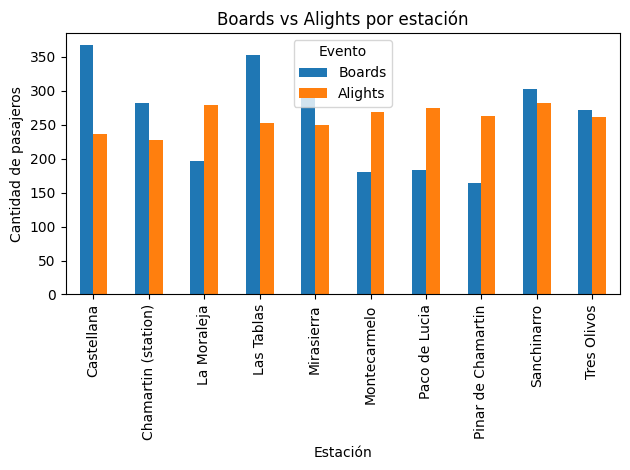

In [20]:
# Agrupamos boards y alights por estación
boards = df[df['Event'] == 'Boards'].groupby('Station').size()
alights = df[df['Event'] == 'Alights'].groupby('Station').size()

events_station = pd.DataFrame({
    'Boards': boards,
    'Alights': alights
}).fillna(0).sort_index()

display(events_station)  # muestra la tabla
plt.figure()
events_station.plot(kind='bar')
plt.xlabel('Estación')
plt.ylabel('Cantidad de pasajeros')
plt.title('Boards vs Alights por estación')
plt.legend(title='Evento')
plt.tight_layout()
plt.show()


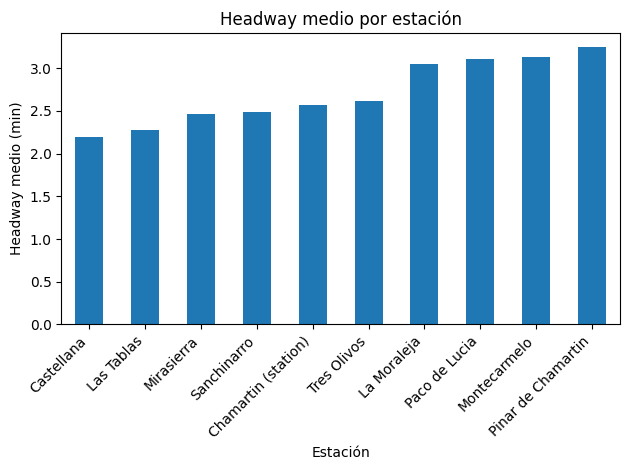

In [19]:
# --- Celda de código: Headway medio por estación ---
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarnos de trabajar con datetime
df['Time_dt'] = pd.to_datetime(df['Time'], format='%H:%M')

# Filtrar sólo las llegadas de tren
train_arr = df[(df['Event']=='Arrives') & (df['Train']!='')][['Station','Time_dt']]

# Calcular headways (diferencia entre llegadas sucesivas) en minutos
train_arr = train_arr.sort_values(['Station','Time_dt'])
headways = train_arr.groupby('Station')['Time_dt'].diff().dt.total_seconds() / 60

# Media de headway por estación
avg_headway = headways.groupby(train_arr['Station']).mean().sort_values()

# Gráfico de barras
plt.figure()
avg_headway.plot(kind='bar')
plt.xlabel('Estación')
plt.ylabel('Headway medio (min)')
plt.title('Headway medio por estación')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


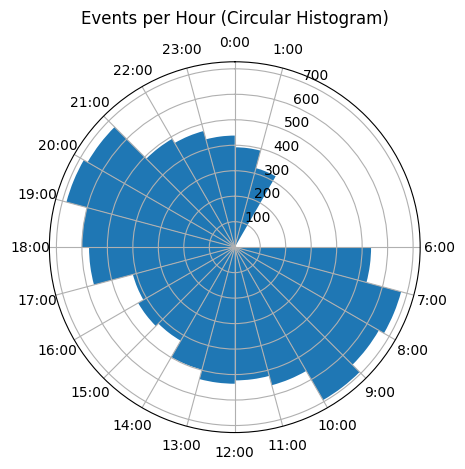

In [22]:
# --- Celda de código: Histograma circular de eventos por hora ---
import numpy as np
import matplotlib.pyplot as plt

# Asegurarnos de tener Time_dt
df['Time_dt'] = pd.to_datetime(df['Time'], format='%H:%M')

# Contar eventos por hora
hourly = df['Time_dt'].dt.hour.value_counts().sort_index()

# Preparamos los ángulos para cada hora (24 barras)
hours = hourly.index.values
counts = hourly.values
angles = 2 * np.pi * hours / 24

# Dibujar en polar
ax = plt.subplot(projection='polar')
bars = ax.bar(angles, counts, width=2*np.pi/24, align='edge')

# Ajustes de estilo
ax.set_xticks(2*np.pi*hours/24)
ax.set_xticklabels([f"{h}:00" for h in hours])
ax.set_theta_zero_location('N')          # 0h arriba
ax.set_theta_direction(-1)               # Horario sentido de las agujas
ax.set_title('Events per Hour (Circular Histogram)', va='bottom')

plt.tight_layout()
plt.show()


# Conclusions

- **PSO finds the best schedule**  
  The PSO algorithm automatically chooses how often trains should run and how many are needed to keep wait times low.

- **Passenger waiting times**  
  Waiting time data shows where people wait longest. PSO uses this to cut down delays, especially at busy stations.

- **Train intervals vs. actual performance**  
  Although trains don’t always arrive exactly on schedule, the average interval PSO suggests keeps things running smoothly.

- **Peak demand hours**  
  Morning and evening rush hours create clear spikes in station activity. PSO adjusts frequency to handle these busy periods.

- **Practical take-away**  
  Using PSO, transit planners can set up train timetables that balance resources and passenger comfort, reducing wait times without running too many trains.

